In [ ]:
# Import packages
from tools.to_read import *
from tools.to_plot import *
from tools.to_do import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set up
root='/home/jacoponudo/Documents/Size_effects/'


# Power Law distribution

#### Fitta le power law

In [ ]:
import pandas as pd
import powerlaw as pwl
import matplotlib.pyplot as plt
import os

# Definizione delle piattaforme da analizzare
platforms = ['gab', 'reddit', 'twitter', 'usenet', 'voat', 'facebook']

# Funzione per caricare e analizzare i dati di ciascuna piattaforma
def analyze_platform_data(platform, root, columns_to_read, standard_columns):
    try:
        # Carica i dati da un file Parquet
        data = pd.read_parquet(root + 'DATA/' + platform + '/' + platform + '_raw_data.parquet', 
                                columns=columns_to_read[platform])
        data.columns = standard_columns
        data['timestamp'] = pd.to_datetime(data['timestamp'])

        # Calcola il numero di utenti unici per post
        unique_users_per_post = data.groupby('post_id')['user_id'].nunique().reset_index()
        unique_users_per_post.columns = ['post_id', 'unique_users_count']

        # Salva i risultati in un CSV
        output_csv_path = os.path.join(root, 'PAPER', 'output', '1_section', f'1_users_in_thread_{platform}.csv')
        unique_users_per_post.to_csv(output_csv_path, index=False)
        
        # Fit della distribuzione Power Law
        fit_function = pwl.Fit(list(unique_users_per_post['unique_users_count']))
        
        # Stampa dei parametri della Power Law
        print(f"\nPlatform: {platform}")
        print(f"Alpha: {fit_function.power_law.alpha}")
        print(f"Sigma: {fit_function.power_law.sigma}")
        print(f"D: {fit_function.power_law.D}")
        
        # Confronto tra la Power Law e una distribuzione esponenziale (opzionale)
        comparison = fit_function.distribution_compare('power_law', 'exponential')
        print(f"Comparison between Power Law and Exponential: {comparison}")
        
        # Plot dei dati e della Power Law adattata
        plt.figure(figsize=(8, 6))
        fit_function.plot_pdf(color='b', linestyle='-', label='Empirical Data')  # PDF empirico
        fit_function.power_law.plot_pdf(color='r', linestyle='--', label='Fitted Power Law')  # Fit della Power Law
        plt.title(f"Power Law Fit for {platform}")
        plt.xlabel('Unique Users per Post')
        plt.ylabel('Probability')
        plt.legend()
        plt.grid(True)

        # Salva il grafico come PNG
        plot_path = os.path.join(root, 'PAPER', 'output', 'plots', f'{platform}_power_law_fit.png')
        plt.savefig(plot_path)
        plt.close()
        
    except Exception as e:
        print(f"Error processing platform {platform}: {e}")



# Ciclo per analizzare ogni piattaforma
for platform in platforms:
    analyze_platform_data(platform, root, columns_to_read, standard_columns)


Calculating best minimal value for power law fit
xmin progress: 99%
Platform: gab
Alpha: 3.5292471415993325
Sigma: 0.03858411923607005
D: 0.02201761290675619
Comparison between Power Law and Exponential: (233.1645088637785, 5.17112302132254e-09)
Calculating best minimal value for power law fit
xmin progress: 99%
Platform: reddit
Alpha: 1.988425228237548
Sigma: 0.006076205998567572
D: 0.02561273260329
Comparison between Power Law and Exponential: (9944.559997522074, 0.0)
Calculating best minimal value for power law fit
xmin progress: 99%
Platform: twitter
Alpha: 2.6312335950842725
Sigma: 0.03133513078484209
D: 0.023856980860095134
Comparison between Power Law and Exponential: (618.1714405113767, 8.789545257449831e-23)


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
xmin progress: 99%
Platform: usenet
Alpha: 4.099637022234884
Sigma: 0.0920053133382796
D: 0.015334687351538312
Comparison between Power Law and Exponential: (99.0338314118738, 1.2524065794596844e-07)
Calculating best minimal value for power law fit
xmin progress: 99%
Platform: voat
Alpha: 6.1853910803927645
Sigma: 0.30608395751402173
D: 0.028074366708991882
Comparison between Power Law and Exponential: (13.29339991551608, 0.20204328005220784)
Calculating best minimal value for power law fit
xmin progress: 99%
Platform: facebook
Alpha: 2.501686647475684
Sigma: 0.06295397916299462
D: 0.017124620461134832
Comparison between Power Law and Exponential: (203.93306221783251, 3.418352652744081e-05)


# Collective

## Lifetime collective

/home/jacoponudo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_382110/3779085521.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['duration_percentile'].fill

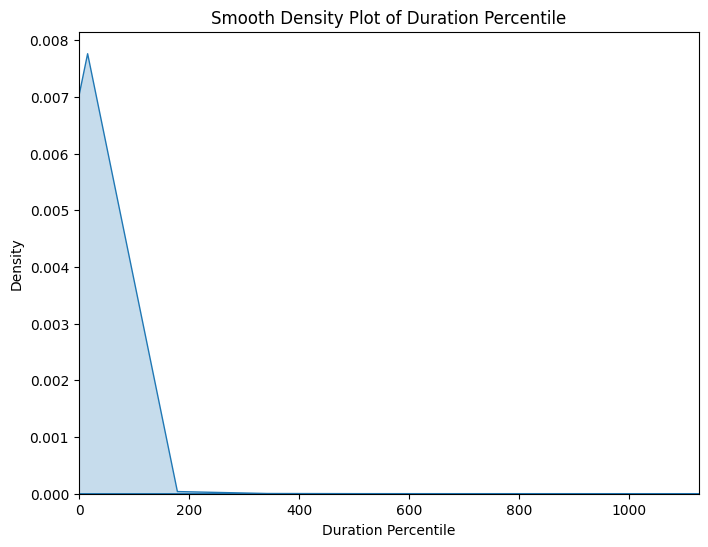

 17%|█▋        | 1/6 [00:13<01:05, 13.07s/it]


AttributeError: 'float' object has no attribute 'total_seconds'

In [1]:
platforms = ['reddit', 'usenet', 'voat','gab', 'facebook','twitter']

from tools.to_read import *
from tools.to_plot import *
from tools.to_do import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.image as mpimg
from tqdm import tqdm
import os
root = '/home/jacoponudo/Documents/Size_effects/' 
for platform in tqdm(platforms):
    data = pd.read_parquet(root + 'DATA/' + platform + '/' + platform + '_raw_data.parquet', columns=columns_to_read[platform])
    data.columns = standard_columns    
    output_path = root + 'PAPER/output/1_section/2_lifetime_thread_{}.csv'.format(platform)
    if not os.path.exists(output_path):
        calculate_lifetime_percentile(data, 80, output_path)
    # Plotting
    df = pd.read_csv(output_path, dtype={'post_id': str})

    # Convert the 'duration_percentile' column to numeric, coercing errors to NaN
    df['duration_percentile'] = pd.to_numeric(df['duration_percentile'], errors='coerce')

    # Replace NaN values with 0
    df['duration_percentile'].fillna(0, inplace=True)

    # Create a smooth density plot of the 'duration_percentile' column with adjusted bandwidth
    plt.figure(figsize=(8, 6))
    sns.kdeplot(df['duration_percentile'], shade=True, bw_method=0.2)  # Adjusted bandwidth for smoothness

    # Set a proper xlim based on the data range
    plt.xlim(df['duration_percentile'].min() - 1, df['duration_percentile'].quantile(0.9995) + 1)

    plt.title("Smooth Density Plot of Duration Percentile")
    plt.xlabel("Duration Percentile")
    plt.ylabel("Density")
    plt.show()

# Individual

## Individual lifetime 

## Numero Tokens

# Alpha

## Plot 4 with Alpha

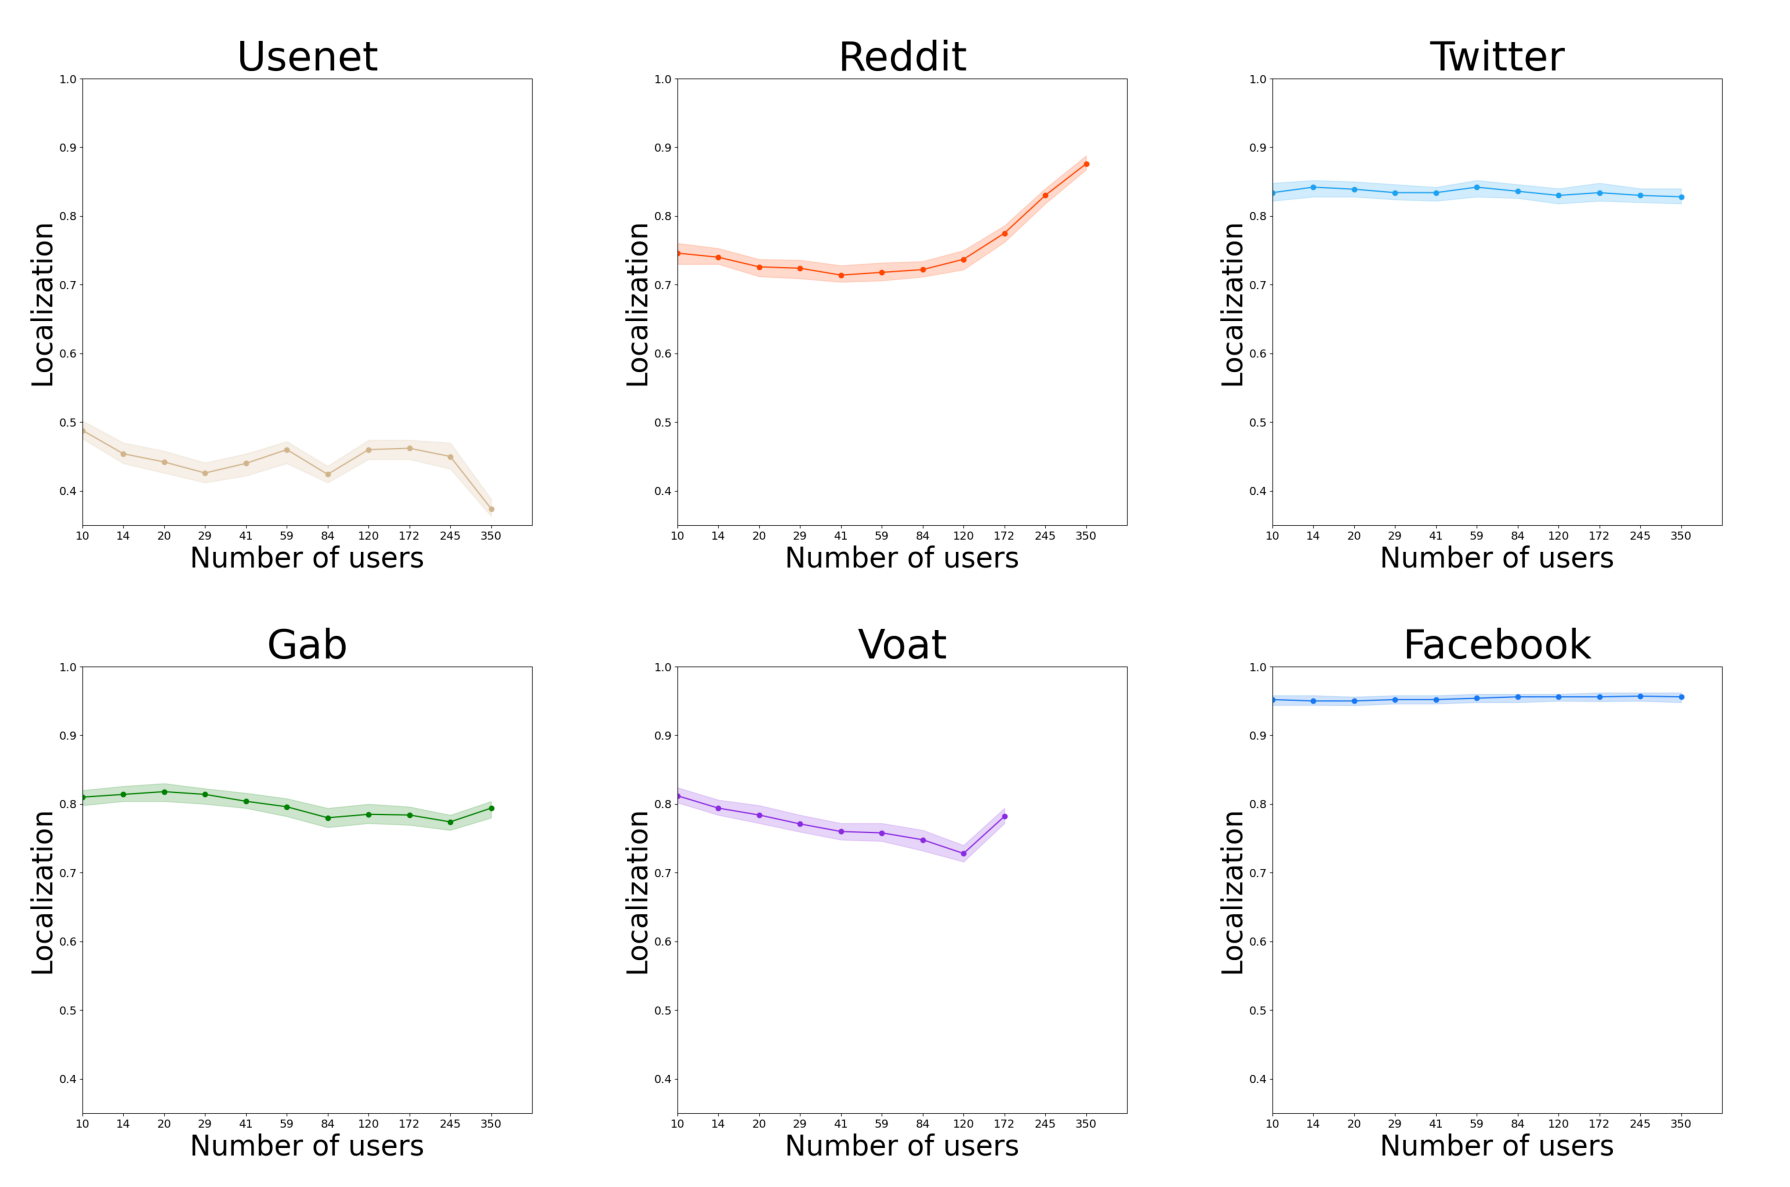

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plots = ['4_dialogue_level'] #['1_users_in_thread', '2_lifetime_thread', '3_concentration_of_comments', '4_dialogue_level']

for i,plot in enumerate(plots):

    images = [
                root + 'PAPER/output/1_section/' + plot + '_usenet_alpha.png',
    root + 'PAPER/output/1_section/' + plot + '_reddit_alpha.png', 
    root + 'PAPER/output/1_section/' + plot + '_twitter_alpha.png',
    root + 'PAPER/output/1_section/' + plot + '_gab_alpha.png', 
    root + 'PAPER/output/1_section/' + plot + '_voat_alpha.png',
    root + 'PAPER/output/1_section/' + plot + '_facebook_alpha.png']
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    for ax, img_path in zip(axes.flat, images):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')  
        
    plt.tight_layout()
    combined_image_path = root + 'PAPER/output/plots/' + plot[0] + '_alpha.png'
    plt.savefig(combined_image_path)
    plt.show()

## Plot 3 with Alpha

/tmp/ipykernel_382110/3345931861.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=df, x="Platform", y="Alpha", kind="violin", inner=None, palette=palette,    height=d1, aspect=1.5)
/tmp/ipykernel_382110/3345931861.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=df, x="Platform", y="Alpha", palette=palette, size=2, ax=g.ax,alpha=0.1)


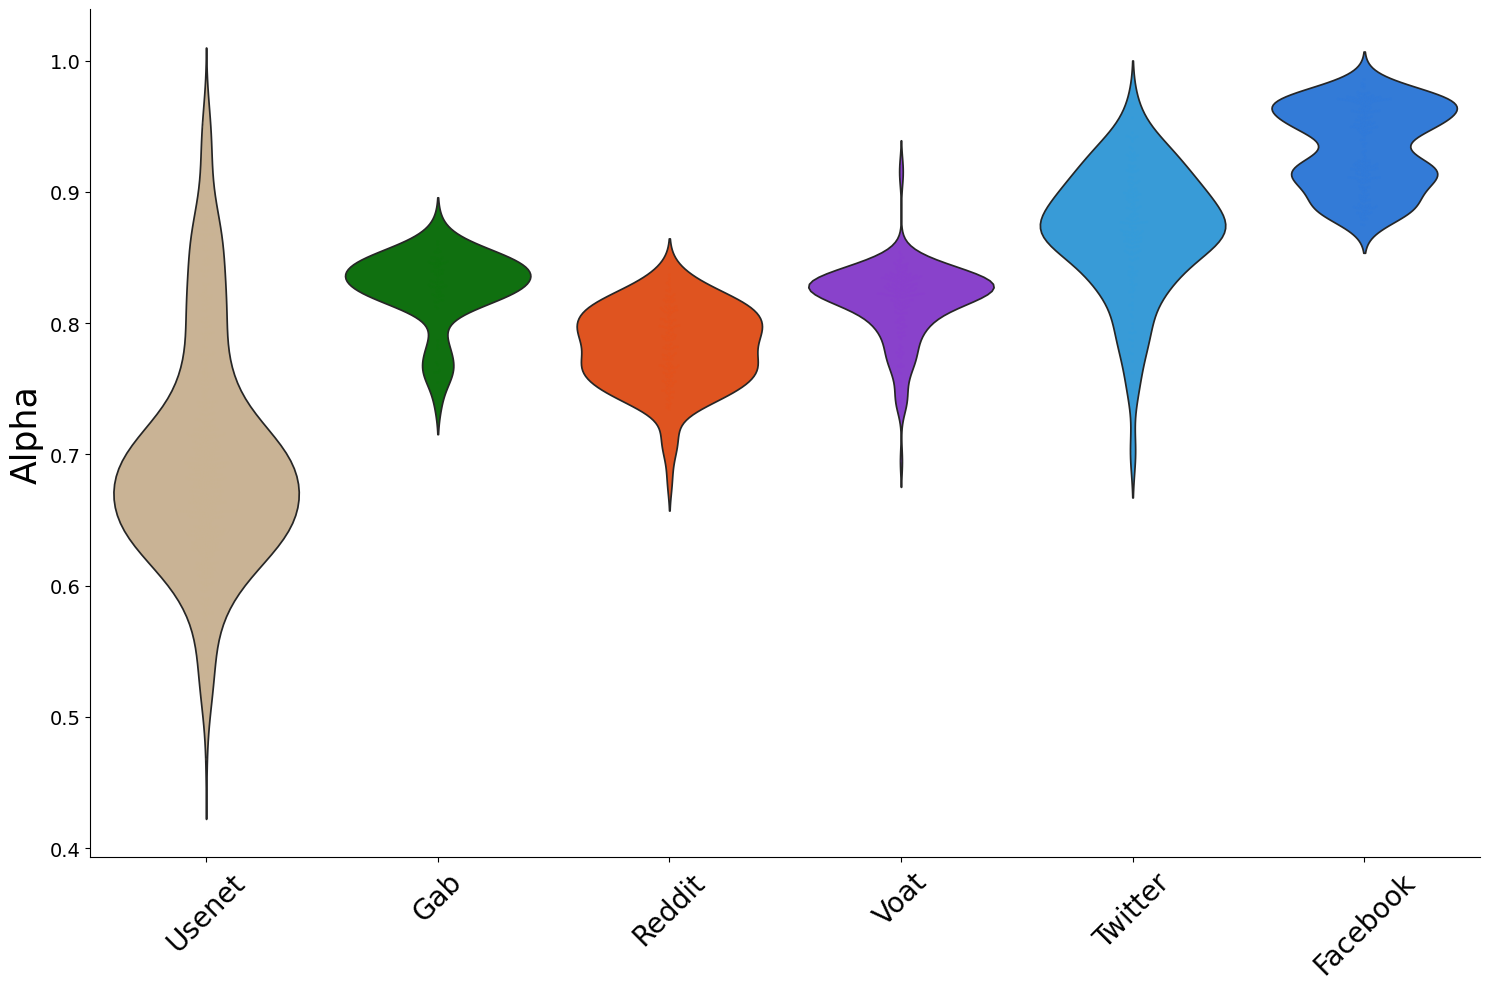

In [2]:
# Import packages
from tools.to_read import *
from tools.to_plot import *
from tools.to_do import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.image as mpimg

# Set up
root='/home/jacoponudo/Documents/Size_effects/'
platforms = ['usenet','gab','reddit',  'voat', 'twitter','facebook']
type='Localization'

# Load the dataset
df = pd.read_csv(root + 'PAPER/output/3_section/boxplot_localization.csv')

# Order the platforms if needed (make sure 'platforms' is defined)
df['Platform'] = pd.Categorical(df['Platform'], categories=platforms, ordered=True)

# Create the violin plot using catplot
g = sns.catplot(data=df, x="Platform", y="Alpha", kind="violin", inner=None, palette=palette,    height=d1, aspect=1.5)

# Add the swarmplot on top of the violin plot
sns.swarmplot(data=df, x="Platform", y="Alpha", palette=palette, size=2, ax=g.ax,alpha=0.1)

# Customizing plot labels and title
plt.xlabel('', fontsize=0)
plt.ylabel('Alpha', fontsize=25)
plt.yticks(fontsize=t)

# Convert platform names to uppercase
plt.xticks(ticks=range(len(platforms)), labels=[platform.capitalize() for platform in platforms], rotation=45,fontsize=20)

# Remove the box around the plot
sns.despine()

plt.tight_layout()
combined_image_path = root + 'PAPER/output/plots/3_alpha.png'
plt.savefig(combined_image_path)
plt.show()

## Plot 5 with alpha

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plots = ['5_size_effect'] #['1_users_in_thread', '2_lifetime_thread', '3_concentration_of_comments', '4_dialogue_level']

for i,plot in enumerate(plots):
    images = [            root + 'PAPER/output/4_section/' + plot + '_usenet_alpha.png',
              root + 'PAPER/output/4_section/' + plot + '_reddit_alpha.png', 
              root + 'PAPER/output/4_section/' + plot + '_twitter_alpha.png',
              root + 'PAPER/output/4_section/' + plot + '_gab_alpha.png', 
              root + 'PAPER/output/4_section/' + plot + '_voat_alpha.png',
              root + 'PAPER/output/4_section/' + plot + '_facebook_alpha.png']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    for ax, img_path in zip(axes.flat, images):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')  

    # Adjust layout
    plt.tight_layout()

    # Save the combined image
    combined_image_path = root + 'PAPER/output/plots/' + plot[0] + '_alpha.png'
    plt.savefig(combined_image_path)
    plt.show()